In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Step 1: MRI Image Loading and Global Intensity Analysis


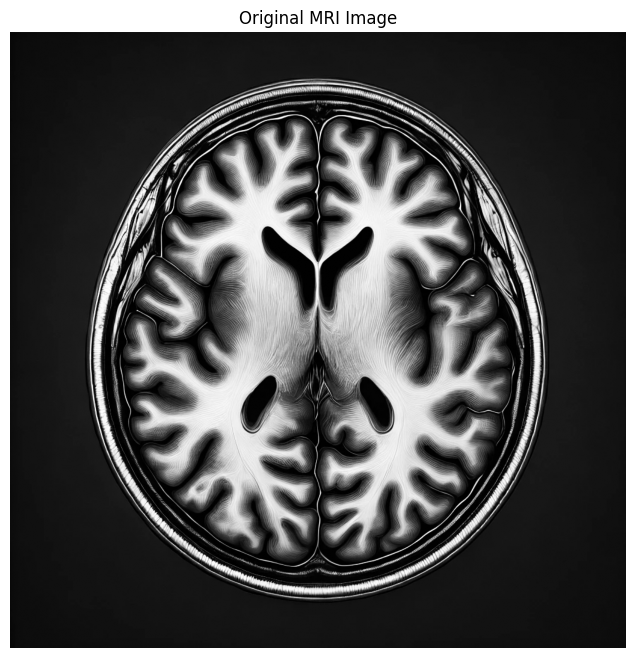

Image Loaded Successfully!
 → Dimensions: Height = 1024 px, Width = 1024 px

Minimum Intensity Value in the Entire Image: 0
 → First occurrence found at (row=77, col=471)
 (Note: This is the first occurrence scanned; there may be others)

Maximum Intensity Value in the Entire Image: 255
 → First occurrence found at (row=97, col=421)
 (Note: This is the first occurrence scanned; there may be others)

Mean Intensity of Entire Image: 64.32
Standard Deviation of Intensities (Full Image): 76.09



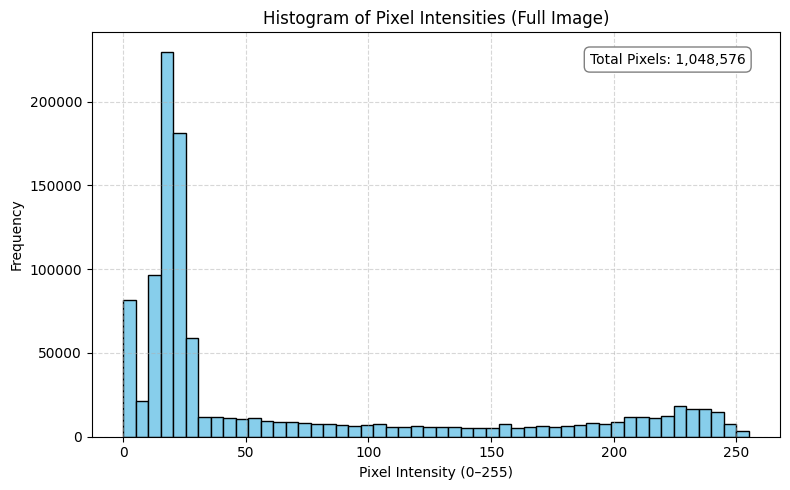

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from PIL import Image

# Load the MRI image
image_path = "/content/drive/MyDrive/Brain MRI Images/Brain_Image_3.webp"
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale

# Check if the image is loaded
if original_img is None:
    print("Error: Image not found. Please check the file path!")
else:
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img, cmap='gray')
    plt.title("Original MRI Image")
    plt.axis('off')
    plt.show()

    # Get image dimensions
    height, width = original_img.shape
    # print(f"✅ Image Loaded Successfully! Dimensions: {height}x{width}")
    print(f"Image Loaded Successfully!")
    print(f" → Dimensions: Height = {height} px, Width = {width} px")

    # Min/Max intensity and positions
    min_intensity = np.min(original_img)
    max_intensity = np.max(original_img)
    min_position = np.unravel_index(np.argmin(original_img), original_img.shape)
    max_position = np.unravel_index(np.argmax(original_img), original_img.shape)

    print(f"\nMinimum Intensity Value in the Entire Image: {min_intensity}")
    print(f" → First occurrence found at (row={min_position[0]}, col={min_position[1]})")
    print(f" (Note: This is the first occurrence scanned; there may be others)\n")

    print(f"Maximum Intensity Value in the Entire Image: {max_intensity}")
    print(f" → First occurrence found at (row={max_position[0]}, col={max_position[1]})")
    print(f" (Note: This is the first occurrence scanned; there may be others)\n")

    # Mean and Standard Deviation
    mean_intensity = np.mean(original_img)
    std_intensity = np.std(original_img)
    print(f"Mean Intensity of Entire Image: {mean_intensity:.2f}")
    print(f"Standard Deviation of Intensities (Full Image): {std_intensity:.2f}\n")

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(original_img.ravel(), bins=50, color='skyblue', edgecolor='black')

    total_pixels = original_img.size
    plt.title("Histogram of Pixel Intensities (Full Image)")
    plt.xlabel("Pixel Intensity (0–255)")
    plt.ylabel("Frequency")

    # Add total pixel count as a text box in the plot
    plt.text(0.95, 0.95, f"Total Pixels: {total_pixels:,}",
            verticalalignment='top',
            horizontalalignment='right',
            transform=plt.gca().transAxes,
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Step 2: Intensity-Based Image Segmentation and Histogram Visualization

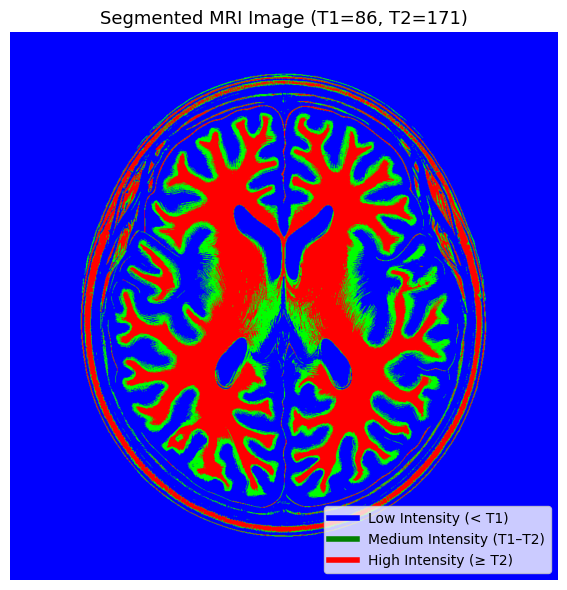


Segmentation Summary:
 - Threshold 1 (T1): 86
 - Threshold 2 (T2): 171

🟦 Low-Intensity Region (< 86): 775,278 pixels (73.94%)
🟩 Medium-Intensity Region (86 ≤ pixel < 171): 102,048 pixels (9.73%)
🟥 High-Intensity Region (≥ 171): 171,250 pixels (16.33%)



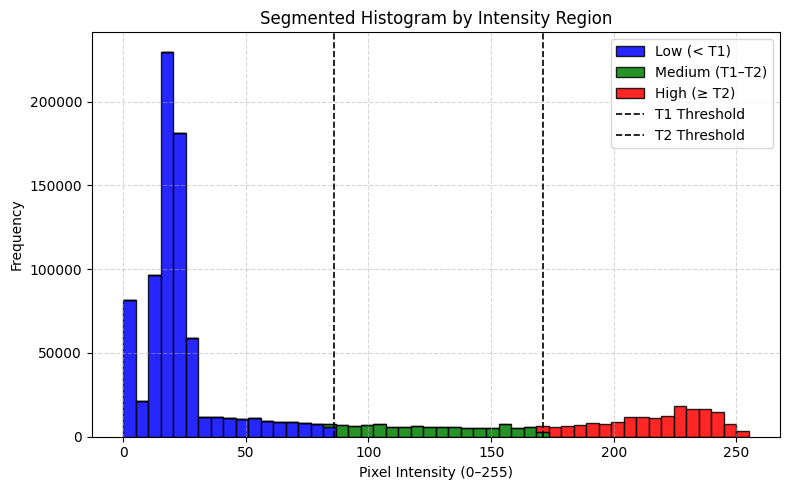

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Thresholds for segmentation (can be tuned or made adaptive)
t1 = 86   # Threshold separating Low and Medium intensities
t2 = 171  # Threshold separating Medium and High intensities

# Segment the image into 3 intensity-based regions
def segment_image(image, t1, t2):
    low_intensity = (image < t1)
    medium_intensity = (image >= t1) & (image < t2)
    high_intensity = (image >= t2)
    return low_intensity, medium_intensity, high_intensity

# Apply segmentation
low_region, medium_region, high_region = segment_image(original_img, t1, t2)

# Create a color-coded RGB visualization
segmented_img = np.zeros((*original_img.shape, 3), dtype=np.uint8)
segmented_img[low_region] = [0, 0, 255]      # Blue for Low
segmented_img[medium_region] = [0, 255, 0]   # Green for Medium
segmented_img[high_region] = [255, 0, 0]     # Red for High

# Display segmented image with legend
plt.figure(figsize=(6, 6))
plt.imshow(segmented_img)
plt.title(f"Segmented MRI Image (T1={t1}, T2={t2})", fontsize=13)
plt.axis('off')

legend_patches = [
    plt.Line2D([0], [0], color='blue', lw=4, label='Low Intensity (< T1)'),
    plt.Line2D([0], [0], color='green', lw=4, label='Medium Intensity (T1–T2)'),
    plt.Line2D([0], [0], color='red', lw=4, label='High Intensity (≥ T2)'),
]
plt.legend(handles=legend_patches, loc='lower right', frameon=True, fontsize=10)
plt.tight_layout()
plt.show()

# === Report Pixel Distribution in Each Region ===
total_pixels = original_img.size
low_count = np.sum(low_region)
med_count = np.sum(medium_region)
high_count = np.sum(high_region)

low_pct = low_count / total_pixels * 100
med_pct = med_count / total_pixels * 100
high_pct = high_count / total_pixels * 100

print("\nSegmentation Summary:")
print(f" - Threshold 1 (T1): {t1}")
print(f" - Threshold 2 (T2): {t2}\n")

print(f"🟦 Low-Intensity Region (< {t1}): {low_count:,} pixels ({low_pct:.2f}%)")
print(f"🟩 Medium-Intensity Region ({t1} ≤ pixel < {t2}): {med_count:,} pixels ({med_pct:.2f}%)")
print(f"🟥 High-Intensity Region (≥ {t2}): {high_count:,} pixels ({high_pct:.2f}%)\n")

# === Optional: Segmentation-Aware Histogram ===
low_values = original_img[original_img < t1]
med_values = original_img[(original_img >= t1) & (original_img < t2)]
high_values = original_img[original_img >= t2]

plt.figure(figsize=(8, 5))
plt.hist([low_values.ravel(), med_values.ravel(), high_values.ravel()],
         bins=50,
         stacked=True,
         color=['blue', 'green', 'red'],
         label=['Low (< T1)', 'Medium (T1–T2)', 'High (≥ T2)'],
         edgecolor='black',
         alpha=0.85)

# Mark thresholds visually
plt.axvline(x=t1, color='black', linestyle='--', linewidth=1.2, label='T1 Threshold')
plt.axvline(x=t2, color='black', linestyle='--', linewidth=1.2, label='T2 Threshold')

plt.title("Segmented Histogram by Intensity Region")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Step 3:


🔹 DEBUGGING: LSB Embedding Process

📍 Pixel[0, 0] = 9 (Binary: 00001001)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00001001
   - New Pixel: 00001001 (Decimal: 9)

📍 Pixel[0, 1] = 9 (Binary: 00001001)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00001001
   - New Pixel: 00001101 (Decimal: 13)

📍 Pixel[0, 2] = 9 (Binary: 00001001)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00001001
   - New Pixel: 00001001 (Decimal: 9)

📍 Pixel[0, 3] = 9 (Binary: 00001001)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00001001
   - New Pixel: 00001001 (Decimal: 9)

📍 Pixel[0, 4] = 11 (Binary: 00001011)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00001011
   - New Pixel: 00001111 (Decimal: 15)

📍 Pixel[0, 5] = 11 (Binary: 00001011)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00001011
   - New Pixel: 00001011 (Decimal: 11)

📍 Pixel[0, 6] = 

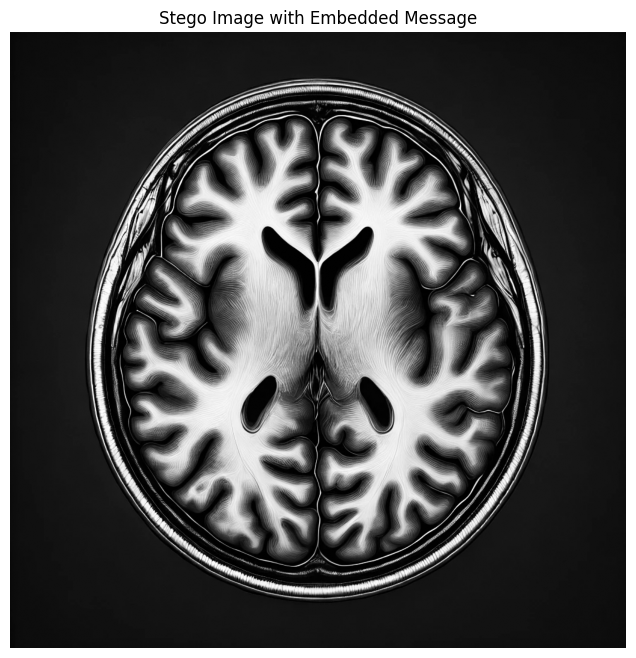

✅ Stego image saved successfully!


In [7]:
def text_to_binary(text):
    """ Convert text message into a binary string """
    return ''.join(format(ord(char), '08b') for char in text)

def embed_lsb_debug(image, message):
    """ Embed secret binary message into LSBs of the MRI image with Debugging Output """
    binary_message = text_to_binary(message) + '1111111111111110'  # End-of-message delimiter
    data_index = 0  # Pointer to track which bit to embed
    stego_image = np.copy(image)  # Make a copy of the image

    print("\n🔹 DEBUGGING: LSB Embedding Process")

    for i in range(image.shape[0]):  # Loop over rows
        for j in range(image.shape[1]):  # Loop over columns
            pixel = image[i, j]  # Get the pixel value

            # Determine the region of the pixel
            if pixel < t1:  # Low-Intensity Region
                lsb_count = 3  # Modify 3rd LSB
            elif t1 <= pixel < t2:  # Medium-Intensity Region
                lsb_count = 2  # Modify 2nd LSB
            else:  # High-Intensity Region
                lsb_count = 1  # Modify 1st LSB

            if data_index < len(binary_message):  # Ensure we still have bits to embed
                message_bit = int(binary_message[data_index])  # Get the bit to embed

                # Debugging prints before modification
                print(f"\n📍 Pixel[{i}, {j}] = {pixel} (Binary: {bin(pixel)[2:].zfill(8)})")
                print(f"   - Region: {'Low' if lsb_count == 3 else 'Medium' if lsb_count == 2 else 'High'}")
                print(f"   - Embedding Bit: {message_bit} into {lsb_count}th LSB")

                # Step 1: Clear the target LSB
                # cleared_pixel = pixel & ~(1 << (lsb_count - 1))
                cleared_pixel = pixel & (~(1 << (lsb_count - 1)) & 0xFF)

                # Step 2: Insert the new bit
                new_pixel = cleared_pixel | (message_bit << (lsb_count - 1))

                # Debugging prints after modification
                print(f"   - Cleared Pixel: {bin(cleared_pixel)[2:].zfill(8)}")
                print(f"   - New Pixel: {bin(new_pixel)[2:].zfill(8)} (Decimal: {new_pixel})")

                stego_image[i, j] = new_pixel  # Replace pixel with modified version
                data_index += 1  # Move to next bit

            if data_index >= len(binary_message):  # Stop if message is fully embedded
                break
        if data_index >= len(binary_message):
            break

    print("\n✅ Steganography Process Completed!")

    return stego_image

# Define a secret message
secret_message = "Hello MRI!"

# Apply LSB embedding with Debugging
stego_img = embed_lsb_debug(original_img, secret_message)

# Display the stego image
plt.figure(figsize=(8,8))
plt.imshow(stego_img, cmap='gray')
plt.title("Stego Image with Embedded Message")
plt.axis('off')
plt.show()

# Save the stego image (optional)
cv2.imwrite("/content/stego_image.png", stego_img)
print("✅ Stego image saved successfully!")

In [ ]:
def binary_to_text(binary_string):
    """ Convert a binary string back to text """
    chars = [chr(int(binary_string[i:i+8], 2)) for i in range(0, len(binary_string), 8)]
    return ''.join(chars)

def extract_lsb(image):
    """ Extract secret binary message from LSBs of the stego image """
    binary_message = ""

    print("\n🔹 DEBUGGING: LSB Extraction Process")

    for i in range(image.shape[0]):  # Loop over rows
        for j in range(image.shape[1]):  # Loop over columns
            pixel = image[i, j]  # Get the pixel value

            # Determine the LSB level based on pixel intensity
            if pixel < t1:  # Low-Intensity Region
                lsb_count = 3  # Extract from 3rd LSB
            elif t1 <= pixel < t2:  # Medium-Intensity Region
                lsb_count = 2  # Extract from 2nd LSB
            else:  # High-Intensity Region
                lsb_count = 1  # Extract from 1st LSB

            # Extract the bit from the pixel
            extracted_bit = (pixel >> (lsb_count - 1)) & 1
            binary_message += str(extracted_bit)  # Append the extracted bit to the message

            # Debugging prints
            if len(binary_message) < 50:  # Print only the first 50 bits for clarity
                print(f"📍 Pixel[{i}, {j}] = {pixel} (Binary: {bin(pixel)[2:].zfill(8)})")
                print(f"   - Region: {'Low' if lsb_count == 3 else 'Medium' if lsb_count == 2 else 'High'}")
                print(f"   - Extracted Bit: {extracted_bit}")

            # Check for the end-of-message delimiter
            if binary_message.endswith("1111111111111110"):
                print("\n✅ End of message detected!")
                break
        if binary_message.endswith("1111111111111110"):
            break

    # Remove the end-of-message delimiter
    binary_message = binary_message[:-16]

    # Convert binary message to text
    extracted_text = binary_to_text(binary_message)

    print(f"\n🔹 Extracted Message: {extracted_text}")
    return extracted_text

# Extract the secret message from the stego image
extracted_message = extract_lsb(stego_img)


🔹 DEBUGGING: LSB Extraction Process
📍 Pixel[0, 0] = 9 (Binary: 00001001)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 1] = 13 (Binary: 00001101)
   - Region: Low
   - Extracted Bit: 1
📍 Pixel[0, 2] = 9 (Binary: 00001001)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 3] = 9 (Binary: 00001001)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 4] = 15 (Binary: 00001111)
   - Region: Low
   - Extracted Bit: 1
📍 Pixel[0, 5] = 11 (Binary: 00001011)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 6] = 11 (Binary: 00001011)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 7] = 11 (Binary: 00001011)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 8] = 11 (Binary: 00001011)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 9] = 15 (Binary: 00001111)
   - Region: Low
   - Extracted Bit: 1
📍 Pixel[0, 10] = 15 (Binary: 00001111)
   - Region: Low
   - Extracted Bit: 1
📍 Pixel[0, 11] = 11 (Binary: 00001011)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 12] = 10 (Binary: 00001010)
 

In [ ]:
from skimage.metrics import structural_similarity as ssim

def compute_metrics(original, stego):
    """ Compute MSE, PSNR, and SSIM for the stego image """
    mse = np.mean((original - stego) ** 2)  # Mean Squared Error

    if mse == 0:
        psnr = float('inf')  # PSNR is infinite if images are identical
    else:
        psnr = 10 * np.log10((255 ** 2) / mse)  # Peak Signal-to-Noise Ratio

    ssim_index = ssim(original, stego, data_range=stego.max() - stego.min())  # Structural Similarity Index

    return mse, psnr, ssim_index

# Compute metrics for the stego image
mse_value, psnr_value, ssim_value = compute_metrics(original_img, stego_img)

# Print the results
print("\n🔹 Image Quality Metrics:")
print(f"✅ Mean Squared Error (MSE): {mse_value:.4f}")
print(f"✅ Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f} dB")
print(f"✅ Structural Similarity Index (SSIM): {ssim_value:.4f}")



🔹 Image Quality Metrics:
✅ Mean Squared Error (MSE): 0.0006
✅ Peak Signal-to-Noise Ratio (PSNR): 80.0631 dB
✅ Structural Similarity Index (SSIM): 1.0000



🔹 Processing Image: /content/drive/MyDrive/Brain MRI Images/Brain_Image_1.jpg

🔹 DEBUGGING: LSB Embedding Process

📍 Pixel[0, 0] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 1] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 2] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 3] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 4] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 5] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Clear

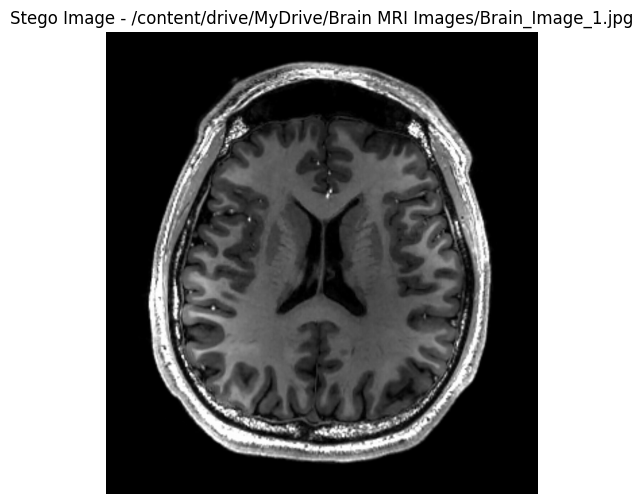


🔹 Processing Image: /content/drive/MyDrive/Brain MRI Images/Brain_Image_2.jpg

🔹 DEBUGGING: LSB Embedding Process

📍 Pixel[0, 0] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 1] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 2] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 3] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 4] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 5] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Clear

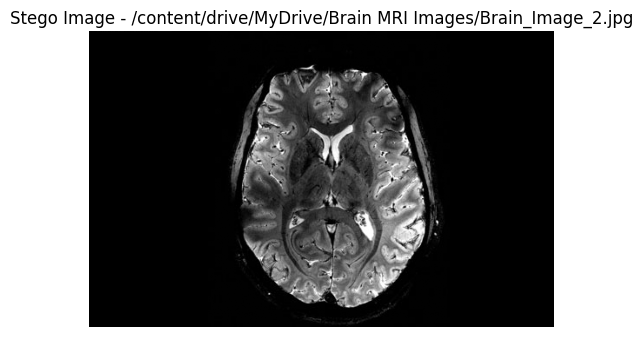


🔹 Processing Image: /content/drive/MyDrive/Brain MRI Images/Brain_Image_4.jpeg

🔹 DEBUGGING: LSB Embedding Process

📍 Pixel[0, 0] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 1] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 2] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 3] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 4] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 5] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Clea

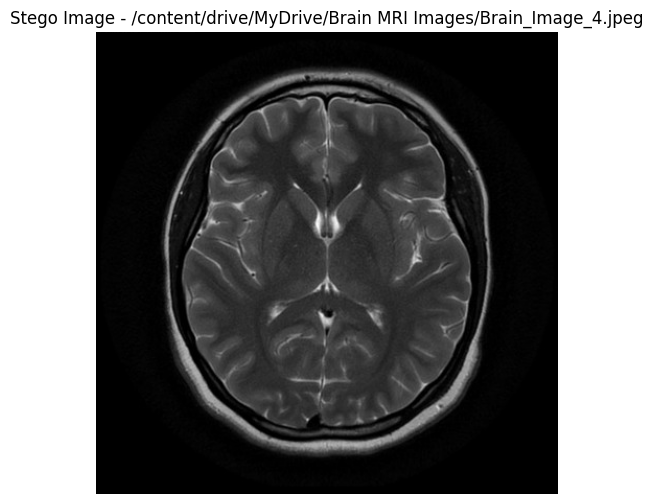

In [ ]:
# List of MRI images to test (change file paths accordingly)
test_images = [
    "/content/drive/MyDrive/Brain MRI Images/Brain_Image_1.jpg",
    "/content/drive/MyDrive/Brain MRI Images/Brain_Image_2.jpg",
    "/content/drive/MyDrive/Brain MRI Images/Brain_Image_4.jpeg",
]

for img_path in test_images:
    print(f"\n🔹 Processing Image: {img_path}")

    # Load MRI image
    test_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded
    if test_img is None:
        print(f"⚠️ Error: Could not load {img_path}")
        continue

    # Embed the same secret message
    stego_test_img = embed_lsb_debug(test_img, secret_message)

    # Compute quality metrics
    mse, psnr, ssim_val = compute_metrics(test_img, stego_test_img)

    # Print results
    print(f"✅ MSE: {mse:.4f}, PSNR: {psnr:.4f} dB, SSIM: {ssim_val:.4f}")

    # Display the new stego image
    plt.figure(figsize=(6,6))
    plt.imshow(stego_test_img, cmap='gray')
    plt.title(f"Stego Image - {img_path}")
    plt.axis('off')
    plt.show()



🔹 Processing Image: /content/drive/MyDrive/Brain MRI Images/Brain_Image_1.jpg

🔹 DEBUGGING: LSB Embedding Process

📍 Pixel[0, 0] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 1] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 2] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 3] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 4] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 5] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Clear

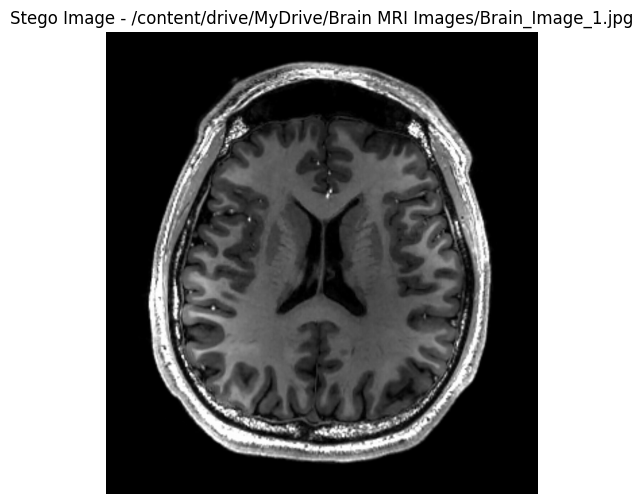


🔹 Processing Image: /content/drive/MyDrive/Brain MRI Images/Brain_Image_2.jpg

🔹 DEBUGGING: LSB Embedding Process

📍 Pixel[0, 0] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 1] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 2] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 3] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 4] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 5] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Clear

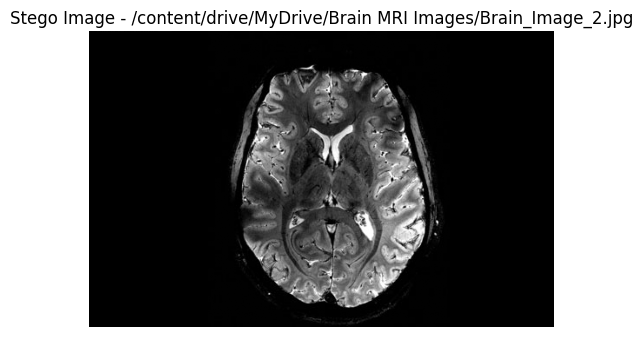


🔹 Processing Image: /content/drive/MyDrive/Brain MRI Images/Brain_Image_4.jpeg

🔹 DEBUGGING: LSB Embedding Process

📍 Pixel[0, 0] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 1] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 2] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 3] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000000 (Decimal: 0)

📍 Pixel[0, 4] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 1 into 3th LSB
   - Cleared Pixel: 00000000
   - New Pixel: 00000100 (Decimal: 4)

📍 Pixel[0, 5] = 0 (Binary: 00000000)
   - Region: Low
   - Embedding Bit: 0 into 3th LSB
   - Clea

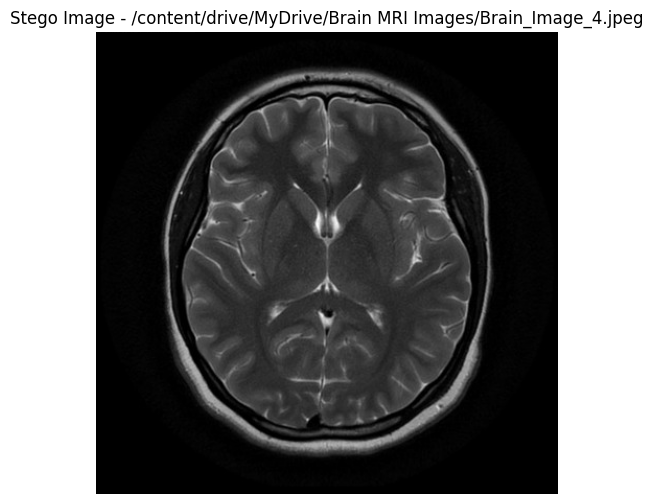


🔹 Comparison Table for All Images:
                Image     MSE  PSNR (dB)  SSIM
0   Brain_Image_1.jpg  0.0005      81.16   1.0
1   Brain_Image_2.jpg  0.0042      71.88   1.0
2  Brain_Image_4.jpeg  0.0039      72.19   1.0


In [ ]:
import pandas as pd

# Prepare a list to store results
results = []

for img_path in test_images:
    print(f"\n🔹 Processing Image: {img_path}")

    test_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if test_img is None:
        print(f"⚠️ Error: Could not load {img_path}")
        continue

    stego_test_img = embed_lsb_debug(test_img, secret_message)
    mse, psnr, ssim_val = compute_metrics(test_img, stego_test_img)

    # Add to results list
    results.append({
        "Image": img_path.split("/")[-1],
        "MSE": round(mse, 4),
        "PSNR (dB)": round(psnr, 2),
        "SSIM": round(ssim_val, 4)
    })

    plt.figure(figsize=(6,6))
    plt.imshow(stego_test_img, cmap='gray')
    plt.title(f"Stego Image - {img_path}")
    plt.axis('off')
    plt.show()

# Display results as a table
df_results = pd.DataFrame(results)
print("\n🔹 Comparison Table for All Images:")
print(df_results)


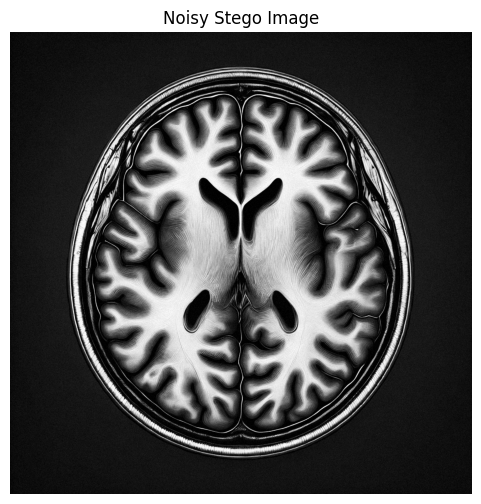


🔹 Attempting extraction from Noisy Stego Image:

🔹 DEBUGGING: LSB Extraction Process
📍 Pixel[0, 0] = 11 (Binary: 00001011)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 1] = 14 (Binary: 00001110)
   - Region: Low
   - Extracted Bit: 1
📍 Pixel[0, 2] = 11 (Binary: 00001011)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 3] = 9 (Binary: 00001001)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 4] = 17 (Binary: 00010001)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 5] = 16 (Binary: 00010000)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 6] = 21 (Binary: 00010101)
   - Region: Low
   - Extracted Bit: 1
📍 Pixel[0, 7] = 8 (Binary: 00001000)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 8] = 9 (Binary: 00001001)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 9] = 19 (Binary: 00010011)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 10] = 10 (Binary: 00001010)
   - Region: Low
   - Extracted Bit: 0
📍 Pixel[0, 11] = 13 (Binary: 00001101)
   - Region: Low
   - Extracte

In [ ]:
def add_gaussian_noise(image, mean=0, std=5):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Add noise to the stego image
noisy_stego_img = add_gaussian_noise(stego_img)

# Display noisy image
plt.figure(figsize=(6,6))
plt.imshow(noisy_stego_img, cmap='gray')
plt.title("Noisy Stego Image")
plt.axis('off')
plt.show()

# Try to extract message from the noisy image
print("\n🔹 Attempting extraction from Noisy Stego Image:")
extracted_from_noisy = extract_lsb(noisy_stego_img)


In [ ]:
# Estimate steganographic capacity
capacity_bits = np.sum(low_region) * 1 + np.sum(medium_region) * 1 + np.sum(high_region) * 1
# You used 1 bit per pixel (only one region uses more, but let’s stay conservative)

# If you want to count per region-specific bit depth:
true_capacity_bits = np.sum(low_region) * 3 + np.sum(medium_region) * 2 + np.sum(high_region) * 1

# Convert to bytes and characters (each char = 8 bits)
true_capacity_bytes = true_capacity_bits // 8
true_capacity_chars = true_capacity_bytes  # Since 1 char = 1 byte

print("\n🔹 Estimated Steganographic Capacity:")
print(f"Total Capacity (bits): {true_capacity_bits}")
print(f"≈ {true_capacity_bytes} bytes / {true_capacity_chars} characters")



🔹 Estimated Steganographic Capacity:
Total Capacity (bits): 2701180
≈ 337647 bytes / 337647 characters
